## Testing raw RF files from the disk.

In [1]:
import arrus
import numpy as np
import pickle
import matplotlib.pyplot as plt

## load the data

- remember to change the path of the input files

In [2]:
data = np.load(f"C:\\Users\\pjarosik\\data\\rf_2020_11_24_09_44_37.npy")
metadata = pickle.load(open(f"C:\\Users\\pjarosik\\data\\metadata_2020_11_24_09_44_37.pkl", 'rb'))

## check frame counter and timestamps 

- checks if the frame counter is a sequence of consecutive values (175 scanlines distance)
- check the timestamp difference between consecutive frames. 

In [3]:
import arrus.metadata
import numpy as np
from arrus.utils.us4r import get_batch_data, get_batch_metadata

batch_size = metadata.data_description.custom["frame_channel_mapping"].batch_size
splitted_metadata = []


for i in range(batch_size):
    splitted_metadata.append(get_batch_metadata(metadata, i))

In [4]:
trigger_counters = []
timestamps = []
for m in splitted_metadata:
    trigger_counters.append(m.custom["frame_metadata_view"][0].copy().view(np.int8)[0:8].view(np.uint64).item())
    timestamps.append(m.custom["frame_metadata_view"][0].copy().view(np.int8)[8:16].view(np.uint64).item()/65e6)

In [5]:
np.diff(trigger_counters)

array([175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
       175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175])

In [6]:
np.diff(timestamps)

array([0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325, 0.017325,
       0.017325, 0.017325, 0.017325, 0.017325, 0.017325])

## Display b-mode images of the acquired data

- frame_nr is the number of frame to be displayed

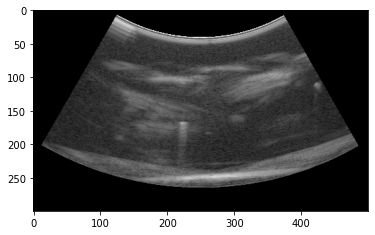

In [7]:
from arrus.utils.imaging import (
    Pipeline,
    BandpassFilter,
    QuadratureDemodulation,
    Decimation,
    RxBeamforming,
    EnvelopeDetection,
    Transpose,
    ScanConversion,
    LogCompression,
    DynamicRangeAdjustment,
    ToGrayscaleImg
)
from arrus.utils.us4r import RemapToLogicalOrder

sess = arrus.Session(mock={})

x_grid = np.arange(-50, 50, 0.2)*1e-3
z_grid = np.arange(0, 60, 0.2)*1e-3

imaging = Pipeline(
    steps=(
        RemapToLogicalOrder(),
        Transpose(axes=(0, 2, 1)),
        BandpassFilter(),
        QuadratureDemodulation(),
        Decimation(decimation_factor=4, cic_order=2),
        RxBeamforming(),
        EnvelopeDetection(),
        Transpose(),
        ScanConversion(x_grid=x_grid, z_grid=z_grid),
        LogCompression(),
        DynamicRangeAdjustment(min=5, max=120),
        ToGrayscaleImg()),
    placement=sess.get_device("/CPU:0"))

frame_nr = 0
rf_data, rf_metadata = get_batch_data(data, metadata, frame_nr), get_batch_metadata(metadata, frame_nr)
bmode, bmode_metadata = imaging(rf_data, rf_metadata)
plt.imshow(bmode, cmap="gray")

Frame shape: (175, 512)


<ipython-input-8-166bd308072f>:15: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(iq_data.T)), cmap="gray")


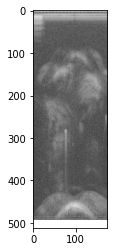

In [8]:
iq_reconstruction_only_pipeline = Pipeline(
    steps=(
        RemapToLogicalOrder(),
        Transpose(axes=(0, 2, 1)),
        BandpassFilter(),
        QuadratureDemodulation(),
        Decimation(decimation_factor=4, cic_order=2),
        RxBeamforming()),
    placement=sess.get_device('/CPU:0'))

frame_nr = 0
rf_data, rf_metadata = get_batch_data(data, metadata, frame_nr), get_batch_metadata(metadata, frame_nr)

iq_data, iq_metadata = iq_reconstruction_only_pipeline(rf_data, rf_metadata)
plt.imshow(np.log(np.abs(iq_data.T)), cmap="gray")

print(f"Frame shape: {iq_data.shape}")